In [2]:
from qutip import *
from qutip.operators import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from cython import *

In [8]:
wa = 1.0  * 2 * np.pi  # atom frequency
g  = 0.05 * 2 * np.pi  # coupling strength
f  = 0.7 * 2 * np.pi  # external field

n_th_a = 0.0           # temperature in frequency units

tlist = np.linspace(0,200,5000)

In [9]:
N_states = 5
ng_steps = 300

#
def njjp1(j,Ej,Ec):
    return ((j+1)/2)**0.5*(Ej/2/Ec)**0.25

def projector(N,n,m):
    # |m><n| operator
    a = np.zeros((N,N),dtype = np.float64)
    if(n >= N or n < 0 or m >= N or m < 0):
        return Qobj(a)
    a[n,m] = 1
    return Qobj(a)
#
def projector_pm(N,n,m):
    a = np.zeros((2*N+1,2*N+1),dtype = np.float64)
    if(n > N or n < -N or m > N or m < -N):
        return Qobj(a)
    a[N+n,N+m] = 1
    return Qobj(a)

#
def num_pm(N):
    return num(2*N+1, offset = -N)    
def zero_pm(N):
    return zero_oper(2*N+1)

In [10]:
Ec = wa
Ej = 2.5*Ec
N_states = 200
n = num_pm(N_states)
ng = 0
Hc = Ec*(n-ng)**2
Hj = zero_pm(N_states)
for n in range(-N_states,N_states+1):
    Hj = Hj - 0.5*Ej*(projector_pm(N_states,n,n+1) + projector_pm(N_states,n+1,n))
H = Hj+Hc
waves = H.eigenstates()[1]
eigens = list(map((lambda wave: [np.real(x[0][0]).item(0) for x in wave]),waves))

IndexError: invalid index to scalar variable.

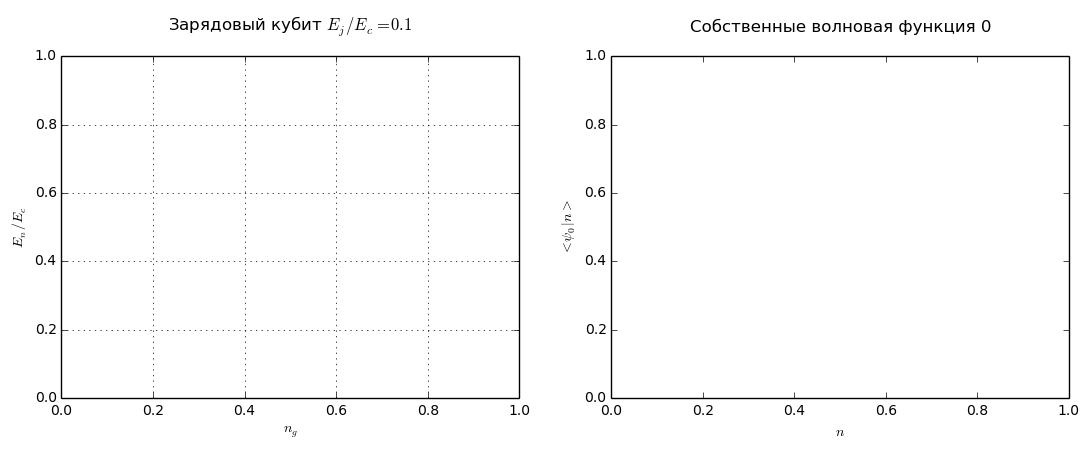

In [29]:
m = 2
num_of_funcs = 2*m + 1
fig = plt.figure(figsize=(13,5*(m+1)),dpi=300)
charge = fig.add_subplot(m+1,2,1)
charge.set_title(r'Зарядовый кубит $E_j/E_c = 0.1$'+'\n')
charge.set_xlabel(r'$n_g$')
charge.set_ylabel(r'$E_n/E_c$')
#charge.plot(ng_space,eigs[:,0:4]/Ec)
charge.grid()
func = [0 for x in range(0,num_of_funcs)]
for j in range(0,num_of_funcs):
    func[j] = fig.add_subplot(m+1,2,2+j)
    func[j].set_title(r'Собственные волновая функция '+str(j)+'\n')
    func[j].set_xlabel(r'$n$')
    func[j].set_ylabel(r'$<\psi_'+str(j)+'|n>$')
    
    w = [np.real(x[0][0][0]) for x in (waves[j])]
    #print(w[N_states-2:N_states+9])
    #func[j].bar(tuple([z for z in range(-2,8+1)]),tuple(w[N_states-2:N_states+9]),1)
    func[j].bar([z for z in range(-N_states, N_states+1)], w,1, align= 'center')
    func[j].set_ylim([-1,1])
    func[j].set_xlim([-m,+m])
fig.tight_layout()
fig.show()
    #funcs.legend(bbox_to_anchor = [0,1], loc = "upper left")

In [24]:
Ec = wa
Ej = 2.5*Ec
N_states = 20
n = num_pm(N_states)
ng = 0
Hc = Ec*(n-ng)**2

f = 1
Hj = zero_pm(N_states)
C = zero_pm(N_states)
for n in range(-N_states,N_states+1):
    Hj = Hj - 0.5*Ej*(projector_pm(N_states,n,n+1) + projector_pm(N_states,n+1,n))

old_N_states = 200
eigens_N = list(map(lambda eigen: [eigen[i] for i in range(old_N_states-N_states,old_N_states+N_states+1)],eigens))

for n in range(0, 2*N_states+2):
    C = C + njjp1(abs(n),Ej,Ec)/njjp1(0,Ej,Ec)*Qobj([eigens_N[n]]).dag()*Qobj([eigens_N[n+1]])
Hq = Hj + Hc

n = num_pm(N_states)
Hf = f * n
Hf_coeff_cython = "sin(t * w + phi)"
Args = {'w' : 1.97*wa, 'phi' : 0}

def Hf_coeff_python(t, args):
    return np.sin(t * args['w'] + args['phi'])

psi0 = Qobj([eigens_N[0]]).dag()
tlist = np.linspace(0,50,400)

In [25]:
c_op_list = []

gamma_relax = 0.00
gamma_dephase_m = 0.001
gamma_dephase_p = 0.00


rate = gamma_dephase_m
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * C)

rate = gamma_dephase_p
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * C.dag())


rate = gamma_relax/2
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * num_pm(N_states))

In [26]:
%%time
H = [Hq, [Hf, Hf_coeff_cython]]
expected = [num_pm(N_states)]
for i in range(-N_states,N_states+1):
    expected.append(projector_pm(N_states, i,i))
output = mesolve(H, psi0, tlist, c_op_list, expected, args = Args,options= Options(nsteps=10000))

/usr/local/lib/python3.4/dist-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


CPU times: user 40min 33s, sys: 9.76 s, total: 40min 43s
Wall time: 40min 26s


In [ ]:
%%time
H = [Hq, [Hf, Hf_coeff_python]]
output = mesolve(H, psi0, tlist, c_op_list, [num_pm(n_states)], args = Args)

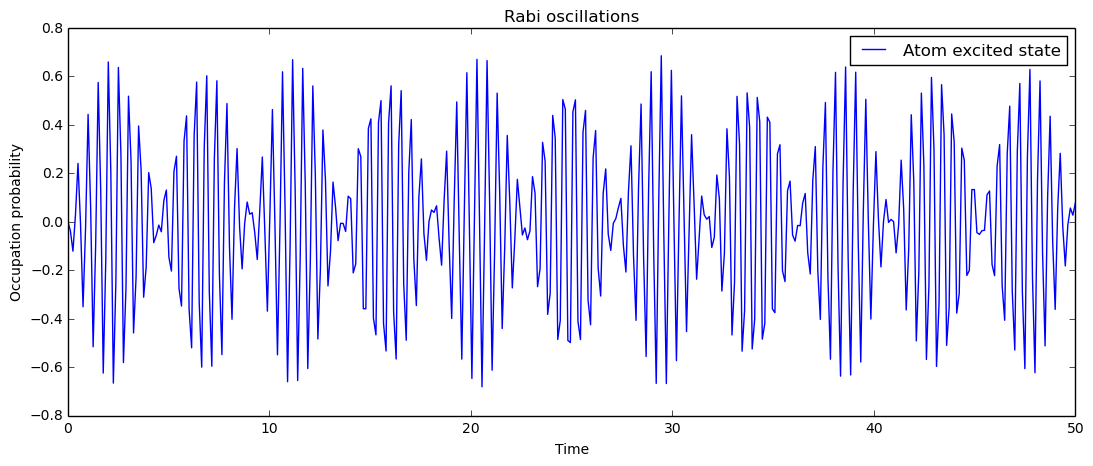

In [28]:
fig, ax = plt.subplots(figsize=(13,5))
ax.plot(tlist, output.expect[0], label="Atom excited state")
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability')
ax.set_title('Rabi oscillations');